In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import matplotlib.gridspec as gridspec # subplots
import numpy as np
import sys
sys.path.append("../")
from energy_based_models.scalar_encoder import ScalarEncoder 
from energy_based_models.energy_based_pooler import EnergyBasedPooler  
from energy_based_models.utils import random_id
import energy_based_models.energy_functions as energy_functions
import energy_based_models.weight_updates as weight_updates
from types import MethodType


bits_per_axis   = 50
weight_per_axis = 5
num_streams     = 4

# Setting up the scalar encoder
sc_enc_params = {
    "dimensions"      : num_streams, 
    "max_values"      : [[0.,1.]]*num_streams,
    "bits_per_axis"   : [bits_per_axis]*num_streams, 
    "weight_per_axis" : [weight_per_axis]*num_streams,
    "wrap_around"     : False
}

# Setting up the sparse coder
sp_coder_params = {
     "inputSize"           : bits_per_axis*4, 
     "outputSize"          : 128, 
     "codeWeight"          : 4, 
     "seed"                : -1,
     "smoothingPeriod"     : 50., 
     "boostStrengthBias"   : 100.,
     "boostStrengthHidden" : 100.,
     "learningRateHidden"  : 0.01,
     "learningRateBias"    : 0.01,
     "weightIncr"          : 0.01,
     "weightDecr"          : 0.01
}

encode_scalar = ScalarEncoder(**sc_enc_params)
coder         = EnergyBasedPooler(**sp_coder_params)
# 
# Re-configure the coder
#
coder.energy         = MethodType(energy_functions.numenta_extended, coder)
coder.update_weights = MethodType(weight_updates.numenta_extended_bounded_by_zero, coder)

print("energy:", coder.energy.__name__)
print("weight updates:", coder.update_weights.__name__)


energy: numenta_extended
weight updates: numenta_extended_bounded_by_zero


# Inputs

In [2]:
"""
Inputs
------
We creating inputs of the form: 

    ``( x, y, y, y )''

To be more precise, for each component we allocate a fixed number
of unitsand encode each component with a scalar encoder.

This is a toy example for the following scenario: We are given 4 input streams, 
such that 3 mutually determine each other, and the remaining one is independent from the rest.

"""
num_inputs = 1000
xs = np.random.sample(num_inputs)
ys = np.random.sample(num_inputs)
input_vectors = np.zeros((num_inputs, coder.input_size))

for i in range(num_inputs):
    input_vectors[i] = encode_scalar([xs[i], ys[i], ys[i], ys[i]])
    
print("{} Inputs sampled.".format(
    num_inputs))
# 
# Example input
# 
# print("Here's an example\n{}".format(
#     input_vectors[np.random.choice(num_inputs)]))

1000 Inputs sampled.


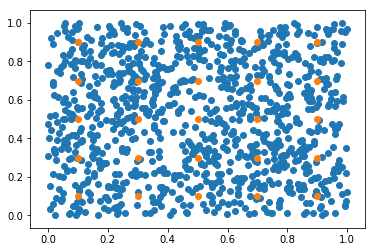

In [3]:
"""
Set up variables to 
document the learning process.
"""
import itertools as it

inputs_fed        = []
outputs_generated = []
landmark_ev       = []
activity_ev       = []
test_inputs       = []
test_output_ev    = []

# 
# Generate test points
# 
step = 0.2
test_points = []
for y,x in it.product(range(5), repeat=2):
    test_points.append( [0.1 + x*step, 0.1 + y*step, 0.1 + y*step, 0.1 + y*step ] )
test_points =  np.array(test_points)

# 
# Generate test vectors from points
# 
test_vectors = np.zeros((len(test_points), coder.input_size))
for i in range(len(test_vectors)):
    test_vectors[i] = encode_scalar(test_points[i])
    
# 
# Show inputs and test points
# 
plt.scatter(xs[0:1000],ys[0:1000])
plt.scatter(test_points[:,0],test_points[:,1])    

# 
# Helper to fill the variables above
# 
def process_milestone():
    test_output_ev.append( coder.encode_batch(test_vectors) )
    landmark_ev .append(coder.connections.visible_to_hidden.copy())
    activity_ev.append(coder.average_activity.copy())

def reconstruct(Y, L):
    return np.dot(Y, L.T)

# Learning

In [4]:
"""
Learn and document 
the evolution of the weights
"""

num_epochs       = 20
batch_size       = 20

milestone_factor = 5 
process_milestone()

for epoch in range(1,num_epochs+1):

    rndm  = np.random.choice(num_inputs, batch_size)
    batch = input_vectors[rndm]
    Y     = coder.learn_batch(batch)
    
    inputs_fed.append(batch)
    outputs_generated.append(Y)
    
    if (epoch - 1) % milestone_factor == 0:

        process_milestone()

        sys.stdout.flush()
        sys.stdout.write("\rEpoch %i" % (epoch -1))
        

print("\nDone learning.")
print("({} total batches learned, {} milestones, {} total inputs)"\
      .format(len(inputs_fed), len(test_output_ev), len(inputs_fed)*batch_size ))


Epoch 15
Done learning.
(20 total batches learned, 5 milestones, 400 total inputs)


# Results and Visualizations

In [5]:
"""
Create a folder and a readme to store
results and a description of how they were achieved
"""
import os

# Adding a random id to make sure we never
# accidently overwrite an older experiment
path   = "./results/test__{id}/"
path   = path.format(id=random_id(4))
prefix = ""
suffix = ""

# A readme file briefly 
# summarizing the setting
readme = """

Inputs
------

 - Input type       : (x,y,y,y)
 - bits per axis    : {bpa}
 - weight per axis  : {wpa}
 - number of streams: {num}

"""

readme = readme.format(bpa = bits_per_axis, wpa = weight_per_axis, num = num_streams )
readme += str(coder)

filename = path + prefix + "README" + suffix + ".md"
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, "w") as f:
    f.write(readme)

In [6]:
"""
Examine the results 
and create visualizations:
    
    ``Scatter plot''
    
"""
import matplotlib.pyplot as plt
import matplotlib.animation as manimation


FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)


name = "scatter_X_vs_Y"
fig  = plt.figure(figsize=(2,6))


with writer.saving(fig, path + prefix + name  + suffix + ".mp4", 100):    
    
    for i in range(len(landmark_ev)):
        Y = test_output_ev[i]
        L = landmark_ev[i]
        n,m = coder.shape
        
        #
        # Create an array of projections on the plane, by         
        # summing the ``x-part'' of the connections and the ``y-part''
        #         
        proj  = np.array([[np.sum(L[j][0:bits_per_axis]), np.sum(L[j][bits_per_axis:])] for j in range(n)]) 
        proj += np.random.sample(proj.shape)*0.2
        
        #         
        # Create the plot and a frame in the movie
        # 
        plt.figure(1)
        plt.xlim(0, weight_per_axis + 1)
        plt.ylim(0, 3*weight_per_axis + 1)

        ax = plt.subplot(111)  
        ax.set_title("norm x-part vs y-part")
        plt.plot(proj[:,0], proj[:,1], '.')

        writer.grab_frame()
        plt.gcf().clear()
        

In [7]:
"""
Examine the results 
and create visualizations:
    
    ``Learned Features''
    
"""

import matplotlib.pyplot as plt
import matplotlib.animation as manimation


FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)


name = "learned_features"
fig = plt.figure()


with writer.saving(fig, path + prefix + name  + suffix + ".mp4", 100):    
    
    for i in range(len(landmark_ev)):
        Y = test_output_ev[i]
        L = landmark_ev[i]
        n,m = coder.shape
        
        #         
        # Create the plot and a frame in the movie
        # 
        plt.figure(1)
        plt.subplot(111) 
        plt.imshow(L[:,:bits_per_axis*2].T, interpolation='none')

        writer.grab_frame()
        plt.gcf().clear()



In [8]:
"""
Examine the results 
and create visualizations:
    
    ``Reconstruction''
    
"""
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from energy_based_models.utils import create_movie

name     = "reconstruction"
filename = path + prefix + name  + suffix + ".mp4"
fig      = plt.figure(figsize=(20,10))

def update_figure(t):

    if not (t < len(landmark_ev)):
        return False
    
    # The frame is grabbed after the update     
    # so we better clean up first
    plt.gcf().clear()
    
    Y = test_output_ev[t]
    L = landmark_ev[t]
    n,m = coder.shape

    #         
    # Create the plot and a frame in the movie
    # 
    plt.figure(1)
    plt.subplot(121) 
    plt.imshow(np.dot(Y, L)[:,:bits_per_axis*2], interpolation='none')
    plt.subplot(122) 
    plt.imshow(test_vectors[:,:bits_per_axis*2], interpolation='none')
    
    return True

create_movie(fig, update_figure, filename, name)

     


# Further visualizations

In [9]:
"""
Order the landmarks by their
connections to X and Y:

 - First, the ones mainly connected to the y-part, 
 - then those whoe are connected to both, and 
 - finally those mainly connected to x-part
 
"""

landmarks = coder.connections.visible_to_hidden.copy()

proj_2d = np.array([[np.sum(landmarks[i][0:bits_per_axis]), np.sum(landmarks[i][bits_per_axis:])] 
            for i in range(landmarks.shape[0])]) 

proj_1d = np.dot(proj_2d, np.array([1., -1.]))


X = np.where(proj_1d > 2.5)[0]
Y = np.where(proj_1d < -7.5)[0]
R = [i for i in range(coder.output_size) if i not in set(X) and i not in set(Y)]

n = coder.output_size


meanX = np.dot(landmarks[X,:bits_per_axis*2], np.arange(bits_per_axis*2))/bits_per_axis*2
X = X[np.argsort(meanX)]

meanY = np.dot(landmarks[Y,:bits_per_axis*2], np.arange(bits_per_axis*2))/bits_per_axis*2
Y = Y[np.argsort(meanY)]

meanR = np.dot(landmarks[[],:bits_per_axis*2], np.arange(bits_per_axis*2))/bits_per_axis*2
R = np.array(R)

order = list(Y) + list(R) + list(X)


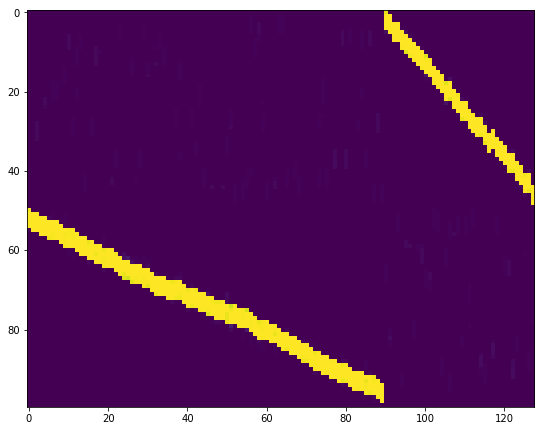

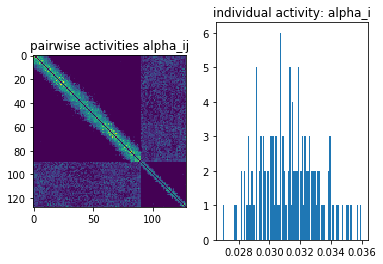

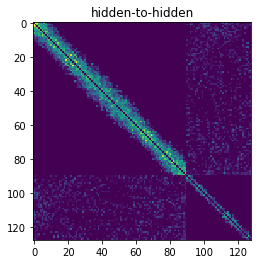

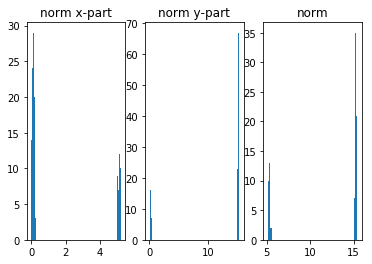

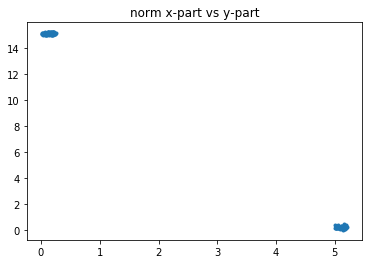

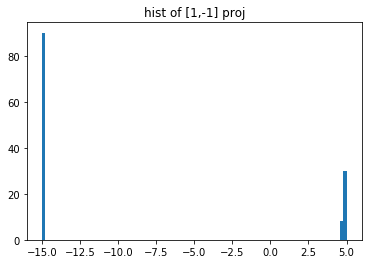

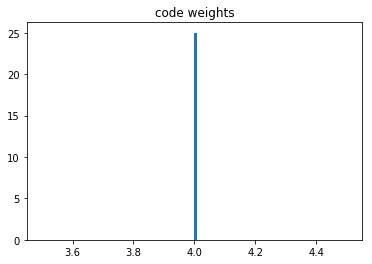

In [10]:
"""
Some plots
"""

# 
#  ordered features
# 
plt.figure(1, figsize=(20,10))
plt.subplot(121)  
plt.imshow(landmarks[order,:bits_per_axis*2].T, interpolation='none')

plt.savefig(path + prefix + 'ordered_landmarks' + suffix + '.png')

# 
#  activities
# 
P = coder.average_activity[order].copy()
for i in range(coder.output_size):
    P[i] = P[i,order]
    P[i,i] = 0.

plt.figure(2)
ax = plt.subplot(121)  
ax.set_title("pairwise activities alpha_ij")
plt.imshow(P)
ax = plt.subplot(122)  
ax.set_title("individual activity: alpha_i")
plt.hist(np.diagonal(coder.average_activity), bins=100)

plt.savefig(path + prefix + 'avgerage_activations' + suffix + '.png')

# 
#  hidden-to-hidden connections
# 
plt.figure(3)
H = coder.connections.hidden_to_hidden[order].copy()
for i in range(coder.output_size):
    H[i] = H[i,order]

ax = plt.subplot(111)  
ax.set_title("hidden-to-hidden")
plt.imshow(H)

plt.savefig(path + prefix + 'hidden-to-hidden' + suffix + '.png')



# 
#  x-part vs y-part
# 
plt.figure(4)
ax = plt.subplot(131)  
ax.set_title("norm x-part")
plt.hist(proj[:,0], bins=100)

ax = plt.subplot(132)  
ax.set_title("norm y-part")
plt.hist(proj[:,1], bins=100)

ax = plt.subplot(133)  
ax.set_title("norm")
plt.hist(proj[:,0] + proj[:,1], bins=100)

# 
#  x-part vs y-part
# 
plt.figure(5)
ax = plt.subplot(111)  
ax.set_title("norm x-part vs y-part")
plt.plot(proj[:,0], proj[:,1], '.')







# 
#   1d projection histogram
# 
plt.figure(6)
ax = plt.subplot(111)  
ax.set_title("hist of [1,-1] proj")
plt.hist(proj_1d, bins=100)


# 
#   code weights
# 
weights = [np.dot(y,y) for y in test_output_ev[-1]]

plt.figure(7)
ax = plt.subplot(111)  
ax.set_title("code weights")
plt.hist(weights, bins=100)

plt.savefig(path + prefix + 'code_weights' + suffix + '.png')



In [23]:
print(coder.energy.__doc__)


    Numenta's energy with an additional term (the H-term) 
    to decorrelate pairwise column activity, but with NO size penalty:
    $$ 
        E(x,y)  = - \sum_i y_i \cdot \exp( - b_i - \sum_j H_{ij} \ y_j ) \cdot (\sum_j W_{ij} \ x_j ) 
    $$
    
